To do:
* Write a class for preprocessing in a pipeline:
    * Add the option to remove the NOX variable.
    * Apply logarithm to PTRATIO, INDUS, and TAX.
* Use only top predictors (corr >= 0.5)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint
from math import ceil

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [2]:
def rm_outliers_below(df, columns):
    """Returns its input dataframe without the lower outliers of the features given in the columns iterable."""
    df2 = df.copy()
    for column in columns:
        Q1 = df2[column].quantile(0.25)
        Q3 = df2[column].quantile(0.75)
        mult = 1.5*(Q3-Q1)
        outlier_ix = df2[df2[column] <= Q1 - mult].index
        df2.drop(index=outlier_ix, inplace = True)
        
    return df2

In [3]:
def rm_outliers_above(df, columns):
    """Returns its input dataframe without the upper outliers of the features given in the columns iterable."""
    df2 = df.copy()
    for column in columns:
        Q1 = df2[column].quantile(0.25)
        Q3 = df2[column].quantile(0.75)
        mult = 1.5*(Q3-Q1)
        outlier_ix = df2[df2[column] >= Q3 + mult].index
        df2.drop(index=outlier_ix, inplace = True)
        
    return df2

In [4]:
def reduce_skew(df, columns):
    """Applies the logarithm to the columns with a skewness greater than 0.5 (not absolute value)."""
    df2 = df.copy()
    for column in columns:
        if df2[column].skew() >= 0.5:
            df2[column] = np.log(df2[column])
    return df2

In [5]:
class FeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, log_features=None, poly_features=None, max_degree=3, drop_features=None):
        self.log_features = log_features #List of features to apply the log to
        self.poly_features = poly_features #List of features to make polynomial
        self.max_degree = max_degree #Maximum polynomial degree
        self.drop_features = drop_features
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_temp = X.copy()
        #y_temp = y.copy()
        #Remove upper outliers from target variable
        #y_temp = rm_outliers_above(y_temp, ['target'])
        #X_temp = X_temp.loc[y_temp.index].copy()
        #Reduce the skew
        reduce_skew(X_temp, X_temp.columns)
        #Remove the NOX variable
        if self.drop_features is not None:
            X_temp = X_temp.drop(columns=self.drop_features)
        #Apply the logarithm to the features of X given by the log_features attribute.
        if self.log_features is not None:
            X_temp.loc[:,self.log_features] = np.log(X_temp[self.log_features])
        #Add polynomial features
        if self.poly_features is not None:
            poly_obj = PolynomialFeatures(degree=self.max_degree, include_bias=False)
            X_poly_features = poly_obj.fit_transform(X_temp[self.poly_features])
            #The first columns of X_poly_features are just the features in the poly_features attribute
            #without transforming, so they have to be removed upon concatenation with X_temp.
            X_temp = np.c_[X_temp.values, X_poly_features[:,len(self.poly_features):]]
            
        return X_temp

In [6]:
def pipeline_grid_search_eval( X_train, y_train, pipe, param_grid):
    """Runs the given datasets through a pipeline, performs a grid search and evaluates its performance through
    cross-validation and mean squared error.
    
    Arguments:
    -pipeline: Sklearn pipeline object. An ML model must be trained at some step in the pipe.
    -param_grid: List of dictionaries with the hyperparamaters to try in the grid search.
    -X_train: NumPy array with the features to be trained on.
    -y_train: NumPy array with the labels used to train and evaluate.
    
    Returns:
    search_res: The fit GridSearchCV
    """
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    search_res = grid_search.fit(X_train, y_train)
    
    best_cv_score = np.sqrt(-search_res.best_score_)
    best_model = search_res.best_estimator_
    best_train_score = np.sqrt(mean_squared_error(y_train, best_model.predict(X_train)))
    
    pprint('Best paramaters:\n' + str(search_res.best_params_))
    print('\n')
    print('''CV error: %.2f
train error: %.2f
Label mean for comparison: %.2f'''%(best_cv_score, best_train_score, y_train.mean()))
    
    return search_res

In [7]:
boston = load_boston()

In [8]:
df = pd.DataFrame(data = np.concatenate((boston['data'], boston['target'].reshape((-1,1))), axis = 1),
                 columns = list(boston['feature_names']) + ['target'])

In [9]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [10]:
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  target   506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


There are no missing values.

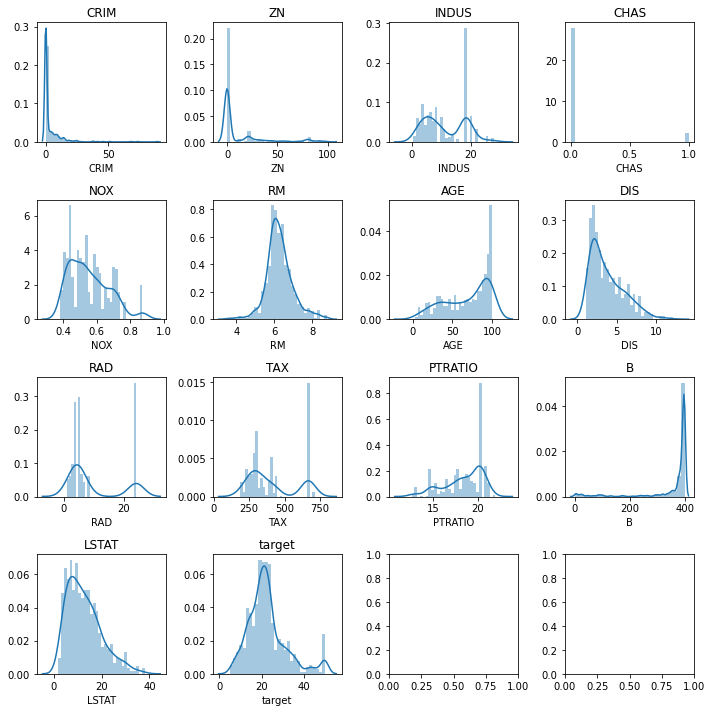

In [12]:
num_cols = len(df.columns)
num_rows = ceil(num_cols**0.5)
fig, ax = plt.subplots(num_rows, num_rows, figsize=(10,10))
c=0
for i in range(num_rows):
    for j in range(num_rows):
        if c>num_cols - 1:
            break
        column = df.columns[c]
        sns.distplot(df[column], bins = 30, ax=ax[i,j])
        ax[i,j].set_title(column)
        c+=1
plt.tight_layout()

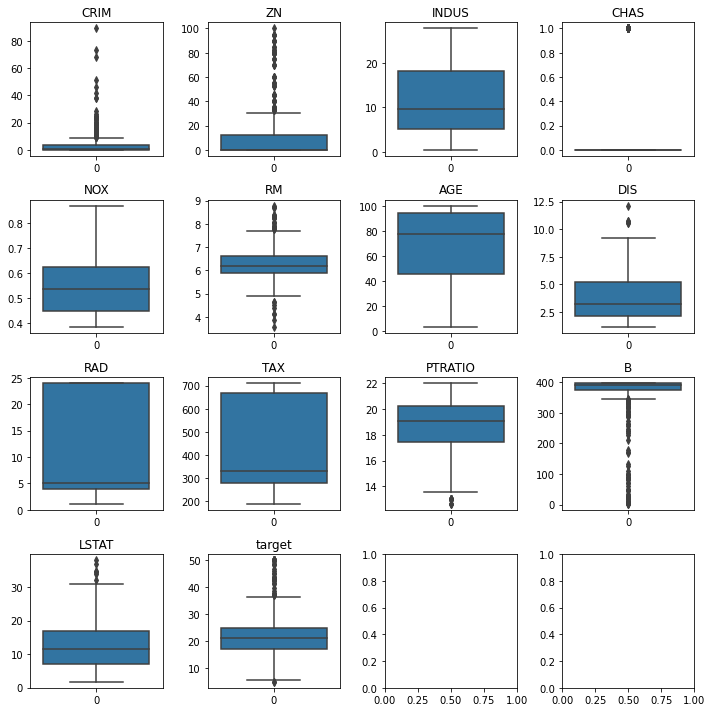

In [13]:
fig, ax = plt.subplots(num_rows, num_rows, figsize=(10,10))
c=0
for i in range(num_rows):
    for j in range(num_rows):
        if c>num_cols - 1:
            break
        column = df.columns[c]
        sns.boxplot(data=df[column], ax=ax[i,j])
        ax[i,j].set_title(column)
        c+=1
plt.tight_layout()

I'll remove the outliers from the target. Not from the CRIM and B features, though, since it's possible they have some information.

## Obtaining train and test sets

In [14]:
df = rm_outliers_above(df, ['target'])

In the absence of any information as to the importance of some specific variable(s), a simple random sample will be made instead of the stratified one in the book.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df['target'], test_size=0.2,
                                                   random_state=42)

In [16]:
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [17]:
#Creating a copy of X_train to visualize
X2 = pd.merge(X_train, y_train, left_index=True, right_index=True)

In [18]:
X2.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.03041,0.0,5.19,0.0,0.515,5.895,59.6,5.6150,5.0,224.0,20.2,394.81,10.56,18.5
1,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2
2,6.80117,0.0,18.10,0.0,0.713,6.081,84.4,2.7175,24.0,666.0,20.2,396.90,14.70,20.0
3,0.18836,0.0,6.91,0.0,0.448,5.786,33.3,5.1004,3.0,233.0,17.9,396.90,14.15,20.0
4,0.06888,0.0,2.46,0.0,0.488,6.144,62.2,2.5979,3.0,193.0,17.8,396.90,9.45,36.2


# Exploring the training set

Checking the correlation between features.

In [19]:
corr_matrix = X2.corr()

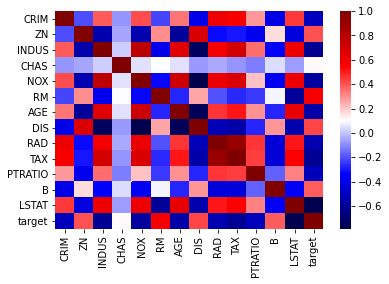

In [20]:
sns.heatmap(corr_matrix, cmap='seismic')

The NOX, TAX, and INDUS variables have a large correlation with each other, as well as RAD and TAX. Heavy negative correlations can be seen between INDUS and DIS, NOX and DIS, and to a lesser extent RM and LSTAT.

Checking the correlations with the target variable.

In [21]:
corr_matrix['target'].sort_values(ascending=False)

target     1.000000
RM         0.585544
DIS        0.432243
ZN         0.412604
B          0.391353
CHAS       0.118194
CRIM      -0.504980
PTRATIO   -0.504980
RAD       -0.529460
AGE       -0.553980
NOX       -0.574931
TAX       -0.605953
INDUS     -0.607943
LSTAT     -0.771426
Name: target, dtype: float64

In [22]:
np.abs(corr_matrix['target']).sort_values(ascending=False)

target     1.000000
LSTAT      0.771426
INDUS      0.607943
TAX        0.605953
RM         0.585544
NOX        0.574931
AGE        0.553980
RAD        0.529460
PTRATIO    0.504980
CRIM       0.504980
DIS        0.432243
ZN         0.412604
B          0.391353
CHAS       0.118194
Name: target, dtype: float64

The two variables most correlated with the target are RM and LSTAT (the latter on the negative side). I'll visualize the variables with the highest absolute values of correlation.

In [23]:
features_sorted_by_corr = np.abs(corr_matrix['target']).sort_values(ascending=False).index

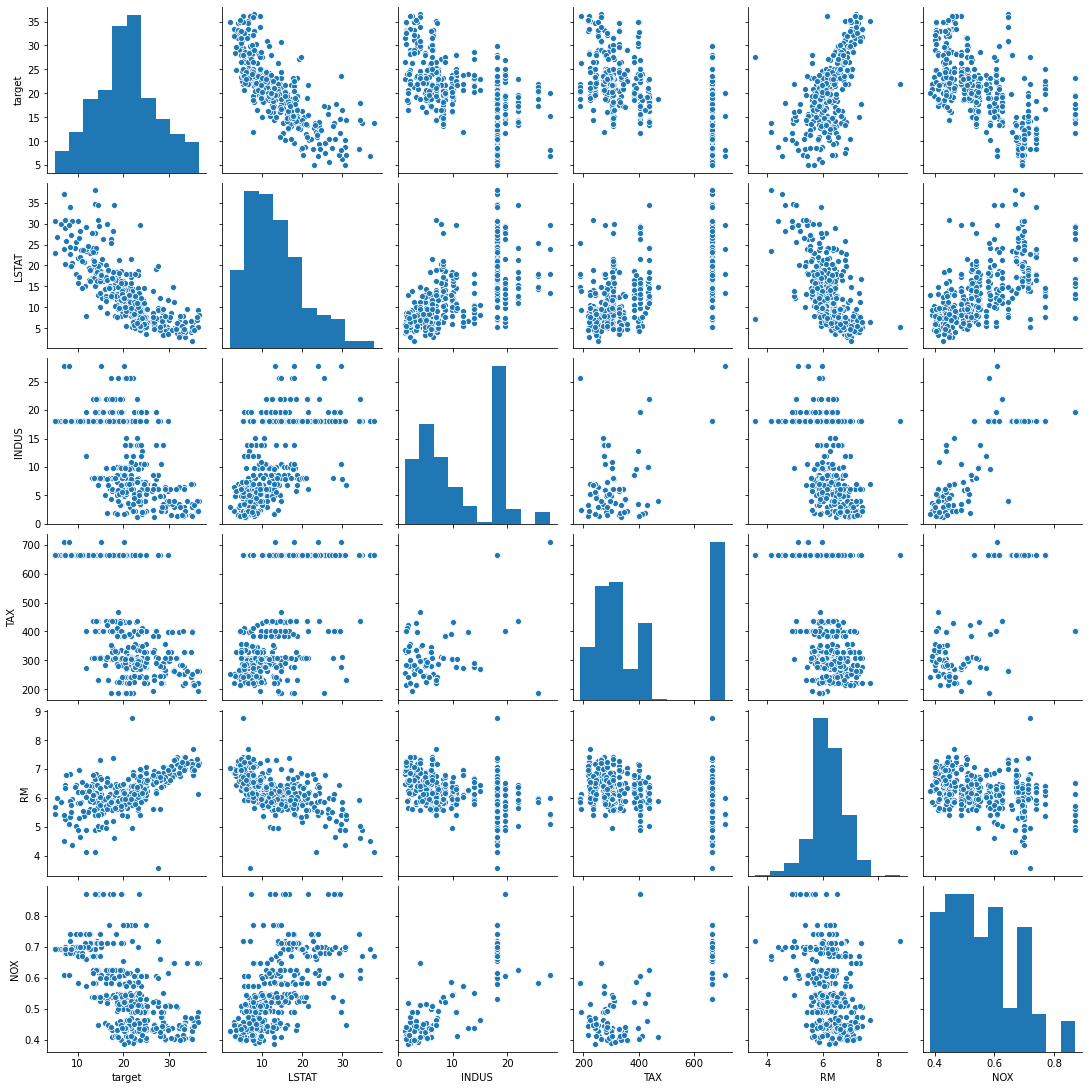

In [24]:
sns.pairplot(X2[features_sorted_by_corr[:6]]);

The relationship between target and RM and target and LSTAT is increasing/decreasing respectively, but the behavior of the other three variables is less obvious. Perhaps a transformation on them would be in order, a logarithm perhaps, to do something about the vertical lines.

Besided that, RM has a horizontal line at the very top, perhaps indicative of the existence of some values cap, such that all values above 50 were forced down.

Finally, RM and LSTAT are very clearly interdependent, although their relationship isn't linear.

# First model

I'll apply a simple first model to get an idea of how it well it performs.

In [25]:
predictors = ['LSTAT', 'RM', 'PTRATIO', 'INDUS', 'TAX']
X2_train = X2[predictors].copy()

In [26]:
scaler = StandardScaler()
X2_train_stand = scaler.fit_transform(X2_train)
X2_train_stand = pd.DataFrame(X2_train_stand, columns=X2_train.columns)

In [27]:
model = LinearRegression()
model.fit(X2_train_stand, y_train)

LinearRegression()

In [28]:
cv_score = cross_val_score(model, X2_train_stand, y_train, cv=5, scoring='neg_mean_squared_error').mean()
cv_score = np.sqrt(-cv_score)

In [29]:
train_score = np.sqrt(mean_squared_error(y_train, model.predict(X2_train_stand)))

In [30]:
print('CV score: %.2f\ntrain score: %.2f\nLabel mean for comparison: %.2f'%(cv_score, train_score, y_train.mean()))

CV score: 3.69
train score: 3.61
Label mean for comparison: 20.70


Since the training set error is smaller than the CV error, the model is overfitting. I'll try to engineer a couple of features next.

# Feature engineering

I'll perform a quick grid search to figure out if it's worth it to apply a polynomial transformation to the LSTAT variable. Also, I'll try several combinations of features to apply a log to.

In [31]:
least_corr_features = list(np.abs(corr_matrix['target']).sort_values().index[:4])

In [32]:
poly_features = [predictors]
#drop_features= [None, 
 #               ['NOX'],
  #              ['NOX', 'TAX', 'LSTAT']]
param_grid = [
    {'feature_transformer__poly_features':poly_features,
     'feature_transformer__max_degree':list(range(2,5))
    }
]

In [33]:
pipe = Pipeline([
    ('feature_transformer', FeatureTransformer()),
    ('standardization', StandardScaler()),
    ('linear_reg', LinearRegression())
])

In [39]:
pipeline_grid_search_eval(X2_train, y_train, pipe, param_grid)

('Best paramaters:\n'
 "{'feature_transformer__max_degree': 2, 'feature_transformer__poly_features': "
 "['LSTAT', 'RM', 'PTRATIO', 'INDUS', 'TAX']}")


CV error: 3.24
train error: 2.88
Label mean for comparison: 20.70


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_transformer',
                                        FeatureTransformer()),
                                       ('standardization', StandardScaler()),
                                       ('linear_reg', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'feature_transformer__max_degree': [2, 3, 4],
                          'feature_transformer__poly_features': [['LSTAT', 'RM',
                                                                  'PTRATIO',
                                                                  'INDUS',
                                                                  'TAX']]}],
             scoring='neg_mean_squared_error')

With the new polynomial and logarithmic features, the train score diminished considerably, and the CV score also went down a little. However, the model is now overfitting, so I'll try regularization.

In [40]:
from sklearn.linear_model import Ridge

In [41]:
reg_param_grid = [
    {'feature_transformer__poly_features':poly_features,
     'feature_transformer__max_degree':list(range(4,6)),
     'ridge_reg__alpha':np.arange(9,15)}
]

In [42]:
reg_pipe = Pipeline([
    ('feature_transformer', FeatureTransformer()),
    ('standardization', StandardScaler()),
    ('ridge_reg', Ridge())
])

In [43]:
pipeline_grid_search_eval(X2_train, y_train, reg_pipe, reg_param_grid)

('Best paramaters:\n'
 "{'feature_transformer__max_degree': 4, 'feature_transformer__poly_features': "
 "['LSTAT', 'RM', 'PTRATIO', 'INDUS', 'TAX'], 'ridge_reg__alpha': 14}")


CV error: 3.19
train error: 2.91
Label mean for comparison: 20.70


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_transformer',
                                        FeatureTransformer()),
                                       ('standardization', StandardScaler()),
                                       ('ridge_reg', Ridge())]),
             n_jobs=-1,
             param_grid=[{'feature_transformer__max_degree': [4, 5],
                          'feature_transformer__poly_features': [['LSTAT', 'RM',
                                                                  'PTRATIO',
                                                                  'INDUS',
                                                                  'TAX']],
                          'ridge_reg__alpha': array([ 9, 10, 11, 12, 13, 14])}],
             scoring='neg_mean_squared_error')

It's still overfitting. Perhaps trying a less complicated model will fix it

# Support vector regressor

In [48]:
svr_pipe = Pipeline([
    ('feature_transformer', FeatureTransformer()),
    ('standardization', StandardScaler()),
    ('SVR', SVR())
])

#Defining a new parameter grid for the SVR
svr_param_grid = [
    {'feature_transformer__poly_features':poly_features,
     'feature_transformer__max_degree':list(range(4,6)),
     'SVR__gamma':np.arange(1,11),
     'SVR__C':np.arange(10,21),
     'SVR__kernel':['linear','rbf']}
]

In [50]:
search_res = pipeline_grid_search_eval( X2_train, y_train, svr_pipe, svr_param_grid)

"Best paramaters:\n{'SVR__C': 11, 'SVR__gamma': 1, 'SVR__kernel': 'rbf'}"


CV error: 3.49
train error: 2.29
Label mean for comparison: 20.70


This one performs actively worse than the linear model, though at least it doesn't overfit as badly. Of note is also that with this model the set of features to apply the log to is different.

# Random forest regressor

In [51]:
forest_pipe = Pipeline([
    ('feature_transformer', FeatureTransformer()),
    ('standardization', StandardScaler()),
    ('random_forest', RandomForestRegressor(n_estimators=200,max_features='sqrt',random_state=42, n_jobs=-1))
])

#Defining a new parameter grid for the SVR
forest_param_grid = [
    {'feature_transformer__poly_features':poly_features,
     'feature_transformer__max_degree':list(range(2,5)),
     #'random_forest__n_estimators': np.arange(100,301,100),
     'random_forest__max_depth':np.arange(10,15),
     #'random_forest__max_leaf_nodes':np.arange(95, 100),
     'random_forest__max_features':['auto', 'sqrt', 'log2']
     }
]

In [53]:
search_res = pipeline_grid_search_eval( X2_train, y_train, forest_pipe, forest_param_grid)

('Best paramaters:\n'
 "{'feature_transformer__max_degree': 2, 'feature_transformer__poly_features': "
 "['LSTAT', 'RM', 'PTRATIO', 'INDUS', 'TAX'], 'random_forest__max_depth': 10, "
 "'random_forest__max_features': 'sqrt'}")


CV error: 3.16
train error: 1.27
Label mean for comparison: 20.70
